In [10]:
import matplotlib
import matplotlib.pyplot as plt

from datasets import get_dataset

import numpy as np
np.random.seed(123)

import random
random.seed(123)

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
set_session(tf.Session(config=config))

from keras.utils import plot_model
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Dropout, Reshape
from keras.optimizers import Adadelta, SGD
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.cluster import KMeans,DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import label_binarize

import cv2
import progressbar
import os
from scipy import stats
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
class SIFT:
    def __init__(self):
        self.sift_object = cv2.xfeatures2d.SIFT_create()
    
    def gray(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return gray
    
    def features(self, image):
        keypoints, descriptors = self.sift_object.detectAndCompute(image, None)
        return [keypoints, descriptors]

    
class BoW:
    def __init__(self, n_clusters = 20):
        self.n_clusters = n_clusters
        self.kmeans_obj = KMeans(n_clusters = n_clusters)
        self.kmeans_ret = None
        self.descriptor_vstack = None
        self.mega_histogram = None
        self.clf  = SVC()

    def cluster(self):
        self.kmeans_ret = self.kmeans_obj.fit_predict(self.descriptor_vstack)

    def developVocabulary(self,n_images, descriptor_list, kmeans_ret = None):
        self.mega_histogram = np.array([np.zeros(self.n_clusters) for i in range(n_images)])
        old_count = 0
        for i in range(n_images):
            l = len(descriptor_list[i])
            for j in range(l):
                if kmeans_ret is None:
                    idx = self.kmeans_ret[old_count+j]
                else:
                    idx = kmeans_ret[old_count+j]
                self.mega_histogram[i][idx] += 1
            old_count += l

    def standardize(self, std=None):
        if std is None:
            self.scale = StandardScaler().fit(self.mega_histogram)
        self.mega_histogram = self.scale.transform(self.mega_histogram)
        else:
            print "STD not none. External STD supplied"
        self.mega_histogram = std.transform(self.mega_histogram)

    def formatND(self, l):
        vStack = np.array(l[0])
        for remaining in l:
            vStack = np.vstack((vStack, remaining))
        self.descriptor_vstack = vStack.copy()
        return vStack


for im in imlist:
    self.train_labels = np.append(self.train_labels, label_count)
    kp, des = self.im_helper.features(im)
    self.descriptor_list.append(des)

    bov_descriptor_stack = bov_helper.formatND(descriptor_list)
    bov_helper.cluster()
    bov_helper.developVocabulary(n_images = self.trainImageCount, descriptor_list=self.descriptor_list)

    bov_helper.standardize()

In [11]:
n_views = 4

In [13]:
# 1. Partition L into (v_1, v_2, ..., v_n)
def get_dset(dataset):
    global n_views
    ds = get_dataset(dataset, 0.7, 0.25)
    [L_x, L_y], U, [test_x, test_y] = ds.get_data()
    L_y = np.argmax(L_y, axis=1)
    test_y = np.argmax(test_y, axis=1)
    
    V = []
    for ind in range(n_views):
        V.append([L_x[indices], L_y[indices]])
    return ds, [L_x, L_y], U, [test_x, test_y], V

In [14]:
# 2. Learn h_i on v_i using Learn
def get_classifiers(test_x, test_y, V):
    H = []
    n_attr = V[0][0].shape[1]

    classifiers = [RandomForestClassifier(max_depth=2, random_state=0)
                   ,AdaBoostClassifier()
                   ,DecisionTreeClassifier(max_depth=5)
                   ,GradientBoostingClassifier()
                   ,KNeighborsClassifier()
                   ,SVC(kernel="linear", C=0.025)
                   ,MLPClassifier()
                   ,SVC(gamma=2, C=1)]
    
    for ind in range(n_views):
        h = classifiers[ind]
        H.append(h)

    for ind in range(n_views):
        H[ind].fit(V[ind][0], V[ind][1])
        print accuracy_score(test_y, H[ind].predict(test_x))
    
    return H, n_attr

In [15]:
# 3
def cotrain(ds, L_x, L_y, U, test_x, test_y, V, H, n_attr):
    changed = True
    to_plot = []
    num_runs = 5
    while (changed and num_runs <= 10):
        print num_runs
        preds_L = []
        for ind in range(n_views):
            preds_L.append(H[ind].predict(L_x))
        preds_L = np.array(preds_L)
        # preds_L = np.argmax(preds_L, axis=2)

        preds_U = []
        for ind in range(n_views):
            preds_U.append(H[ind].predict(U))
        preds_U = np.array(preds_U)
        # preds_U = np.argmax(preds_U, axis=2)

        perfs = []
        test_preds = []
        for ind in range(n_views):
            test_preds.append(H[ind].predict(test_x))
        test_preds = np.array(test_preds)

        for ind in range(n_views):
            perf = accuracy_score(test_y, test_preds[ind])
            perfs.append(perf)
        perfs.append(accuracy_score(test_y,
                                    np.reshape(stats.mode(test_preds, axis=0)[0], (-1,))))
        to_plot.append(perfs)

        Q = []
        update = [False for _ in range(n_views)]
        for cur in range(n_views):
            elems_take = [view_ind for view_ind in range(n_views) if view_ind != cur]
            preds_others_L = preds_L[elems_take]
            preds_others_U = preds_U[elems_take]
            # pdb.set_trace()
            acc_others_L = accuracy_score(L_y, 
                                          np.reshape(stats.mode(preds_others_L, axis=0)[0], (-1,)))
            acc_cur_L = accuracy_score(L_y, preds_L[cur])
            q_cur = [[], []]
            if acc_others_L > acc_cur_L:
                update[cur] = True
                for u_ind in range(preds_U.shape[1]):
                    mode_prediction = stats.mode(preds_others_U[:, u_ind])[0][0]
                    if np.sum(preds_others_U[:, u_ind] == mode_prediction) >= 0.5 * (n_views - 1):
                        q_cur[0].append(U[u_ind])
                        label_temp = mode_prediction
                        q_cur[1].append(label_temp)
            Q.append([np.array(q_cur[0]), np.array(q_cur[1])])
        for cur in range(n_views):
            if update[cur]:
                comb_x = np.concatenate([L_x, Q[cur][0]], axis=0)
                comb_y = np.concatenate([L_y, Q[cur][1]], axis=0)
                H[cur].fit(comb_x, comb_y)

        preds_L_new = []
        for ind in range(n_views):
            preds_L_new.append(H[ind].predict(L_x))

        preds_U_new = []
        for ind in range(n_views):
            preds_U_new.append(H[ind].predict(U))

        same = np.array_equal(preds_L, np.array(preds_L_new)) and np.array_equal(preds_U, np.array(preds_U_new))
        changed = not same
        num_runs += 1
    return to_plot

In [16]:
def plot(to_plot, n_views, dset):
    plt.figure(figsize=(7, 7))
    plt.clf()
    handles = []
    labels = []
    for ind in range(n_views):
        ys = [x[ind] for x in to_plot]
        handle, = plt.plot(range(len(to_plot)), ys, marker='o', label = str(ind))
        handles.append(handle)
        labels.append('Classifier %d' % ind)
    ys = [x[n_views] for x in to_plot]
    handle, = plt.plot(range(len(to_plot)), ys, marker='o', label = 'Overall')
    handles.append(handle)
    labels.append('Max Voting')

    plt.legend(handles, labels, bbox_to_anchor=(1.04,1), loc="upper left")
    # plt.legend(handles, labels)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Iterations vs accuracy for Dataset: %s' % dset)
    plt.show()

0.649122807018
0.748538011696
0.842105263158
5
6
7
8


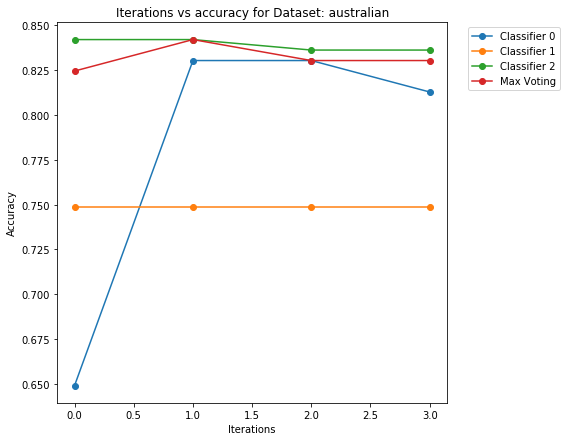

0.627906976744
0.720930232558
0.604651162791
5
6
7


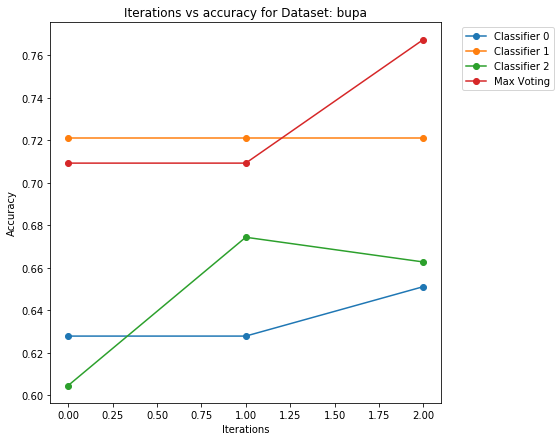

0.75
0.630434782609
0.663043478261
5
6
7


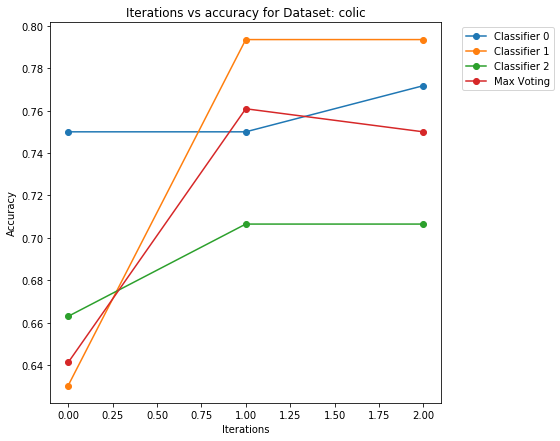

0.692708333333
0.734375
0.567708333333
0.614583333333
0.541666666667
0.755208333333
5
6
7
8
9
10


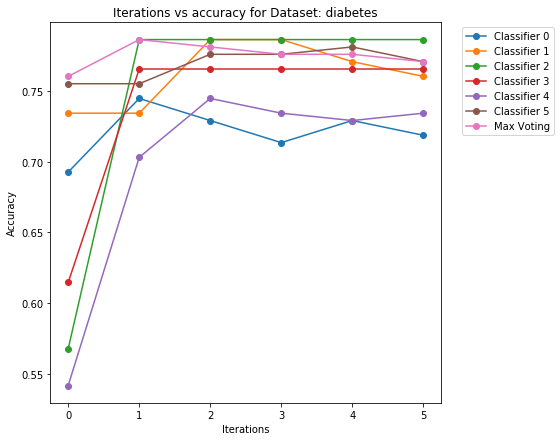

0.508
0.704
0.668
0.644
0.66
0.724
5
6
7
8
9


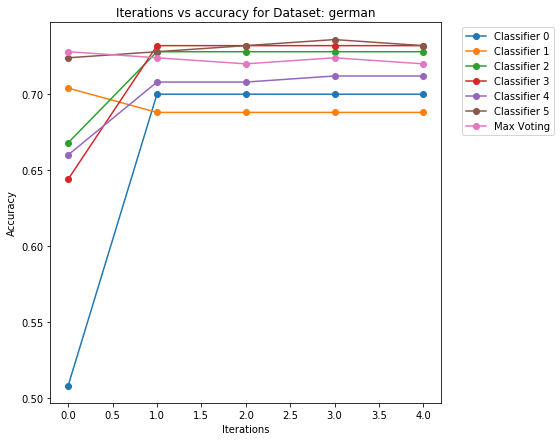

0.735632183908
0.64367816092
5
6
7
8


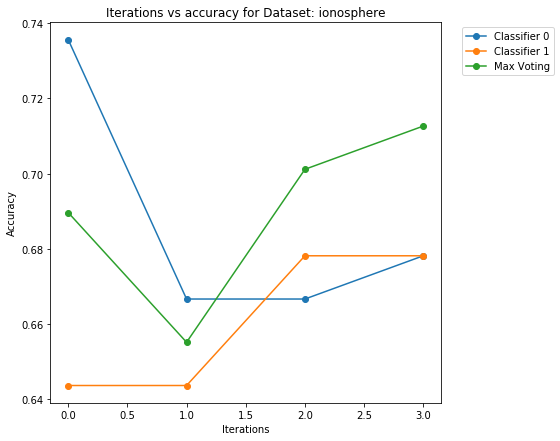

0.701754385965
0.631578947368
0.694235588972
0.918546365915
0.691729323308
0.522556390977
0.595238095238
0.522556390977
5
6
7
8
9


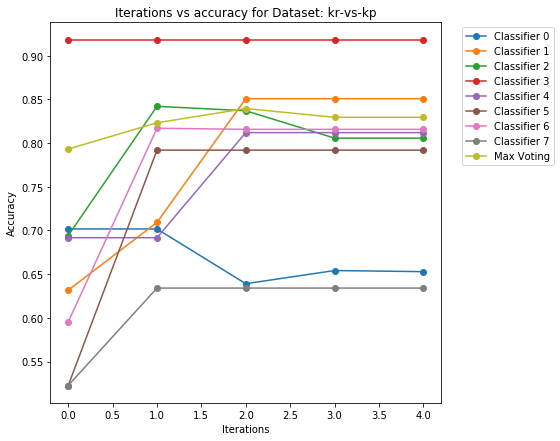

0.623430962343
0.665271966527
0.430962343096
0.619246861925
0.623430962343
0.652719665272
0.401673640167


ValueError: The number of classes has to be greater than one; got 1

In [17]:
for dset in ['australian', 'bupa', 'colic', 'diabetes', 'german', 'ionosphere', 'kr-vs-kp', 'tic-tac-toe', 'vote', 'wdbc']:
    ds, [L_x, L_y], U, [test_x, test_y], V = get_dset(dset)
    H, n_attr = get_classifiers(test_x, test_y, V)
    to_plot = cotrain(ds, L_x, L_y, U, test_x, test_y, V, H, n_attr)
    plot(to_plot, n_views, dset)